# 11章 事前学習済みモデルの利用

In [29]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

# GPUチェック

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 共通関数の読み込み

In [30]:
# 共通関数のダウンロード
!git clone https://github.com/makaishi2/pythonlibs.git

# 共通関数のロード
from pythonlibs.torch_lib1 import *

# 共通関数の存在チェック
print(README)

fatal: destination path 'pythonlibs' already exists and is not an empty directory.
Common Library for PyTorch
Author: M. Akaishi


## 11.5 データ準備

In [31]:
# 分類先クラス名の定義

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 分類先クラス数　今回は10になる
n_output = len(classes)

In [32]:
# Transformsの定義

# 学習データ用: 正規化に追加で反転とRandomErasingを実施
transform_train = transforms.Compose([
  transforms.Resize(112),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5),
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# 検証データ用 : 正規化のみ実施
transform = transforms.Compose([
  transforms.Resize(112),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [33]:
# データ取得用関数 Dataset

data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform_train)

# 検証データの取得
test_set = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
# バッチサイズ指定
batch_size = 50

# データローダー

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

## 11.6 ResNet18の読み込み

### モデルの読み込み

In [35]:
#  必要ライブラリのロード
from torchvision import models

# 事前学習済みモデルのロード
# pretraind = True で学習済みパラメータも一緒に読み込む
net = models.resnet18(pretrained = True)

### モデル構造の確認

In [36]:
# ネットワークの概要表示

print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
# モデルのサマリー表示
net = net.to(device)
summary(net,(100,3,112,112))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [100, 1000]               --
├─Conv2d: 1-1                            [100, 64, 56, 56]         9,408
├─BatchNorm2d: 1-2                       [100, 64, 56, 56]         128
├─ReLU: 1-3                              [100, 64, 56, 56]         --
├─MaxPool2d: 1-4                         [100, 64, 28, 28]         --
├─Sequential: 1-5                        [100, 64, 28, 28]         --
│    └─BasicBlock: 2-1                   [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-1                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-2             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-3                    [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-4                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-6                    [100, 64, 28, 28]         --
│

In [38]:
print(net.fc)
print(net.fc.in_features)

Linear(in_features=512, out_features=1000, bias=True)
512


## 11.7 最終レイヤー関数の付け替え

In [39]:
# 乱数の初期化
torch_seed()

# 最終レイヤー関数の入力次元数を確認
fc_in_features = net.fc.in_features

# 最終レイヤー関数の付け替え
net.fc = nn.Linear(fc_in_features, n_output)

In [40]:
# 確認
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
net = net.to(device)
summary(net,(100,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [100, 10]                 --
├─Conv2d: 1-1                            [100, 64, 112, 112]       9,408
├─BatchNorm2d: 1-2                       [100, 64, 112, 112]       128
├─ReLU: 1-3                              [100, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [100, 64, 56, 56]         --
├─Sequential: 1-5                        [100, 64, 56, 56]         --
│    └─BasicBlock: 2-1                   [100, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [100, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-2             [100, 64, 56, 56]         128
│    │    └─ReLU: 3-3                    [100, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [100, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 56, 56]         128
│    │    └─ReLU: 3-6                    [100, 64, 56, 56]         --
│

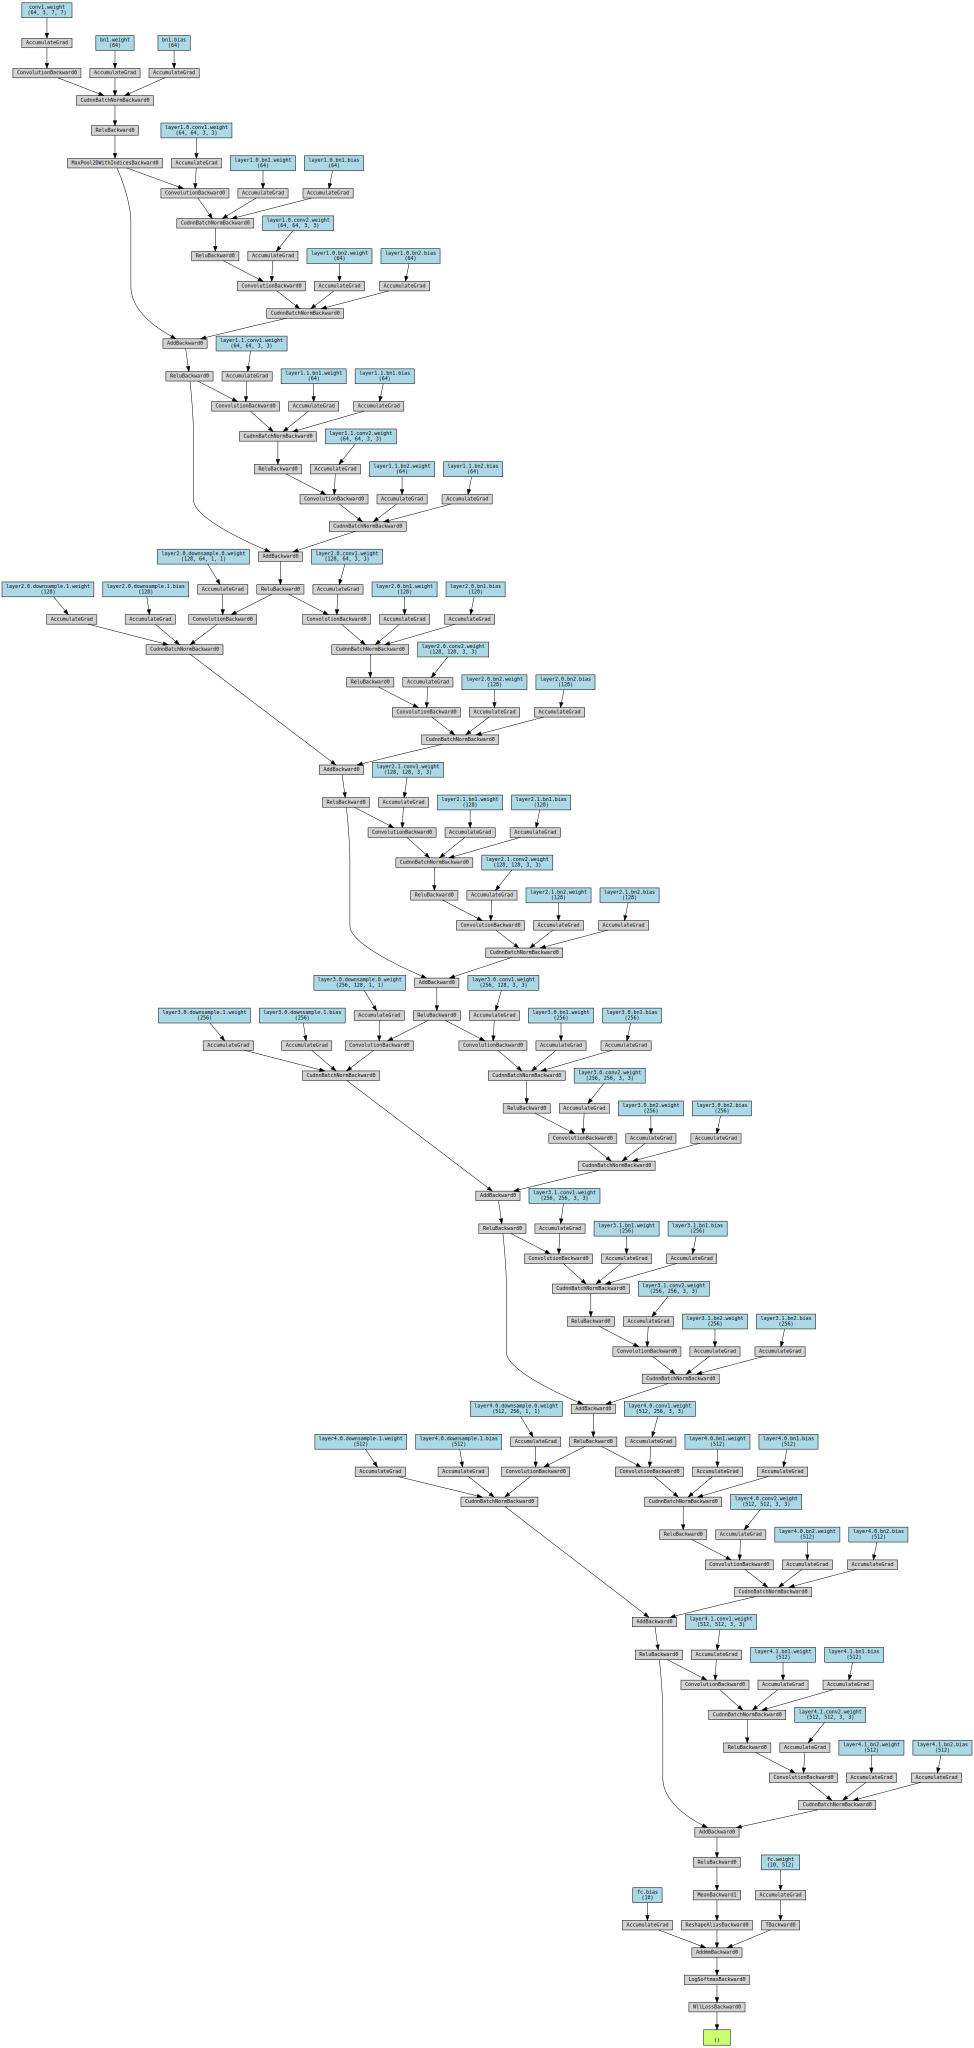

In [42]:
# 損失の計算グラフ可視化

criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [43]:
# 確認
print(net)

# モデルのサマリー表示
net = net.to(device)
summary(net,(100,3,112,112))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [100, 10]                 --
├─Conv2d: 1-1                            [100, 64, 56, 56]         9,408
├─BatchNorm2d: 1-2                       [100, 64, 56, 56]         128
├─ReLU: 1-3                              [100, 64, 56, 56]         --
├─MaxPool2d: 1-4                         [100, 64, 28, 28]         --
├─Sequential: 1-5                        [100, 64, 28, 28]         --
│    └─BasicBlock: 2-1                   [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-1                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-2             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-3                    [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-4                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-6                    [100, 64, 28, 28]         --
│

## 11.8 学習と結果評価

### 最適化関数などの定義

In [44]:
# 乱数の初期化
torch_seed()

# 事前学習済みモデルのロード
# pretraind = True で学習済みパラメータも一緒に読み込む
net = models.resnet18(pretrained = True)

# 最終レイヤー関数の入力次元数を確認
fc_in_features = net.fc.in_features

# 最終レイヤー関数の付け替え
net.fc = nn.Linear(fc_in_features, n_output)

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# historyファイル初期化する
history = np.zeros((0, 5))

### 学習

In [45]:
# 学習
#colab(無料)では3時間21分27秒
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs,
        train_loader, test_loader, device, history)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.60332 acc: 0.79438 val_loss: 0.27659, val_acc: 0.90400


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.32231 acc: 0.88866 val_loss: 0.20297, val_acc: 0.92850


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.25673 acc: 0.91108 val_loss: 0.18772, val_acc: 0.93480


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.21849 acc: 0.92396 val_loss: 0.18414, val_acc: 0.93760


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.19197 acc: 0.93354 val_loss: 0.18649, val_acc: 0.93720


### 結果確認

初期状態: 損失: 0.27659 精度: 0.90400
最終状態: 損失: 0.18649 精度: 0.93720


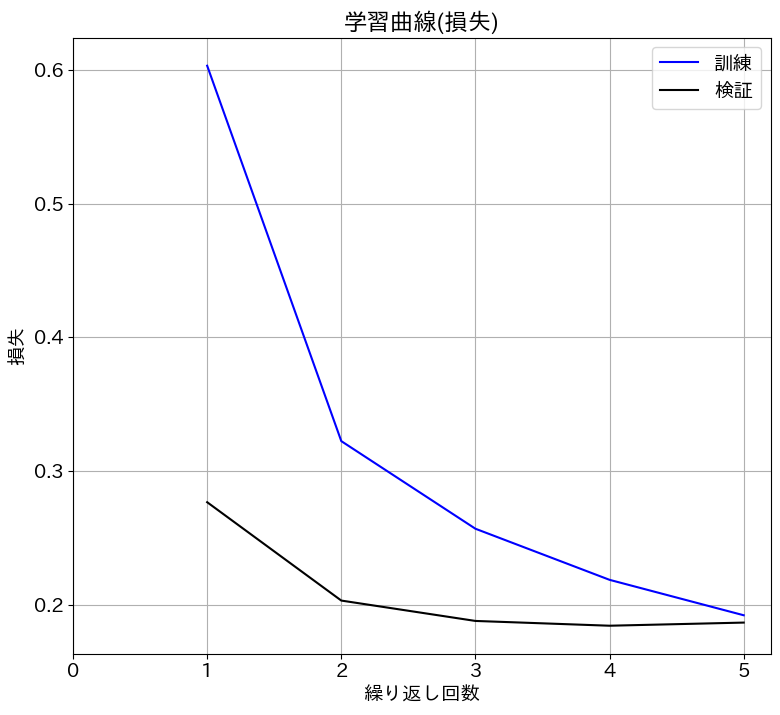

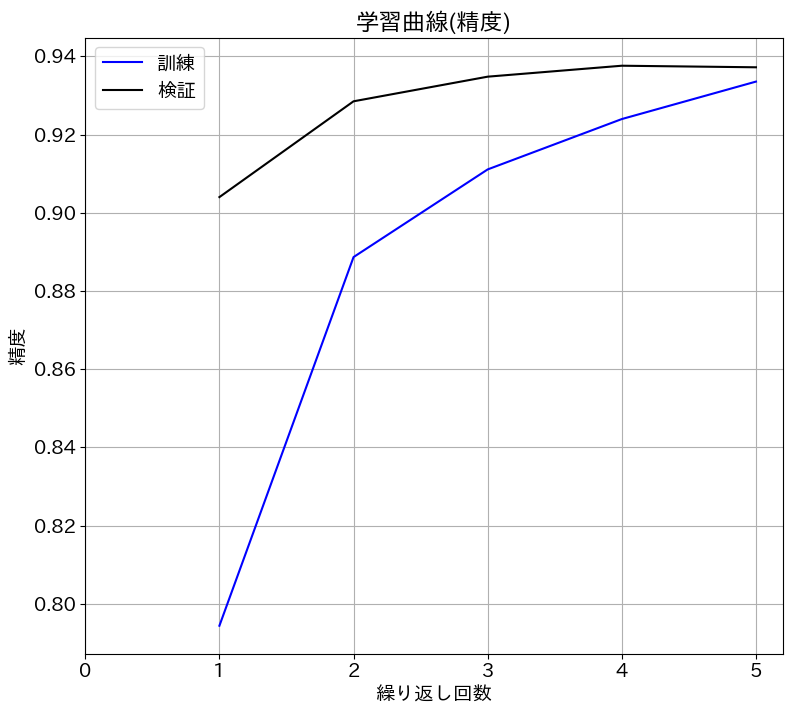

In [46]:
# 結果サマリー
evaluate_history(history)

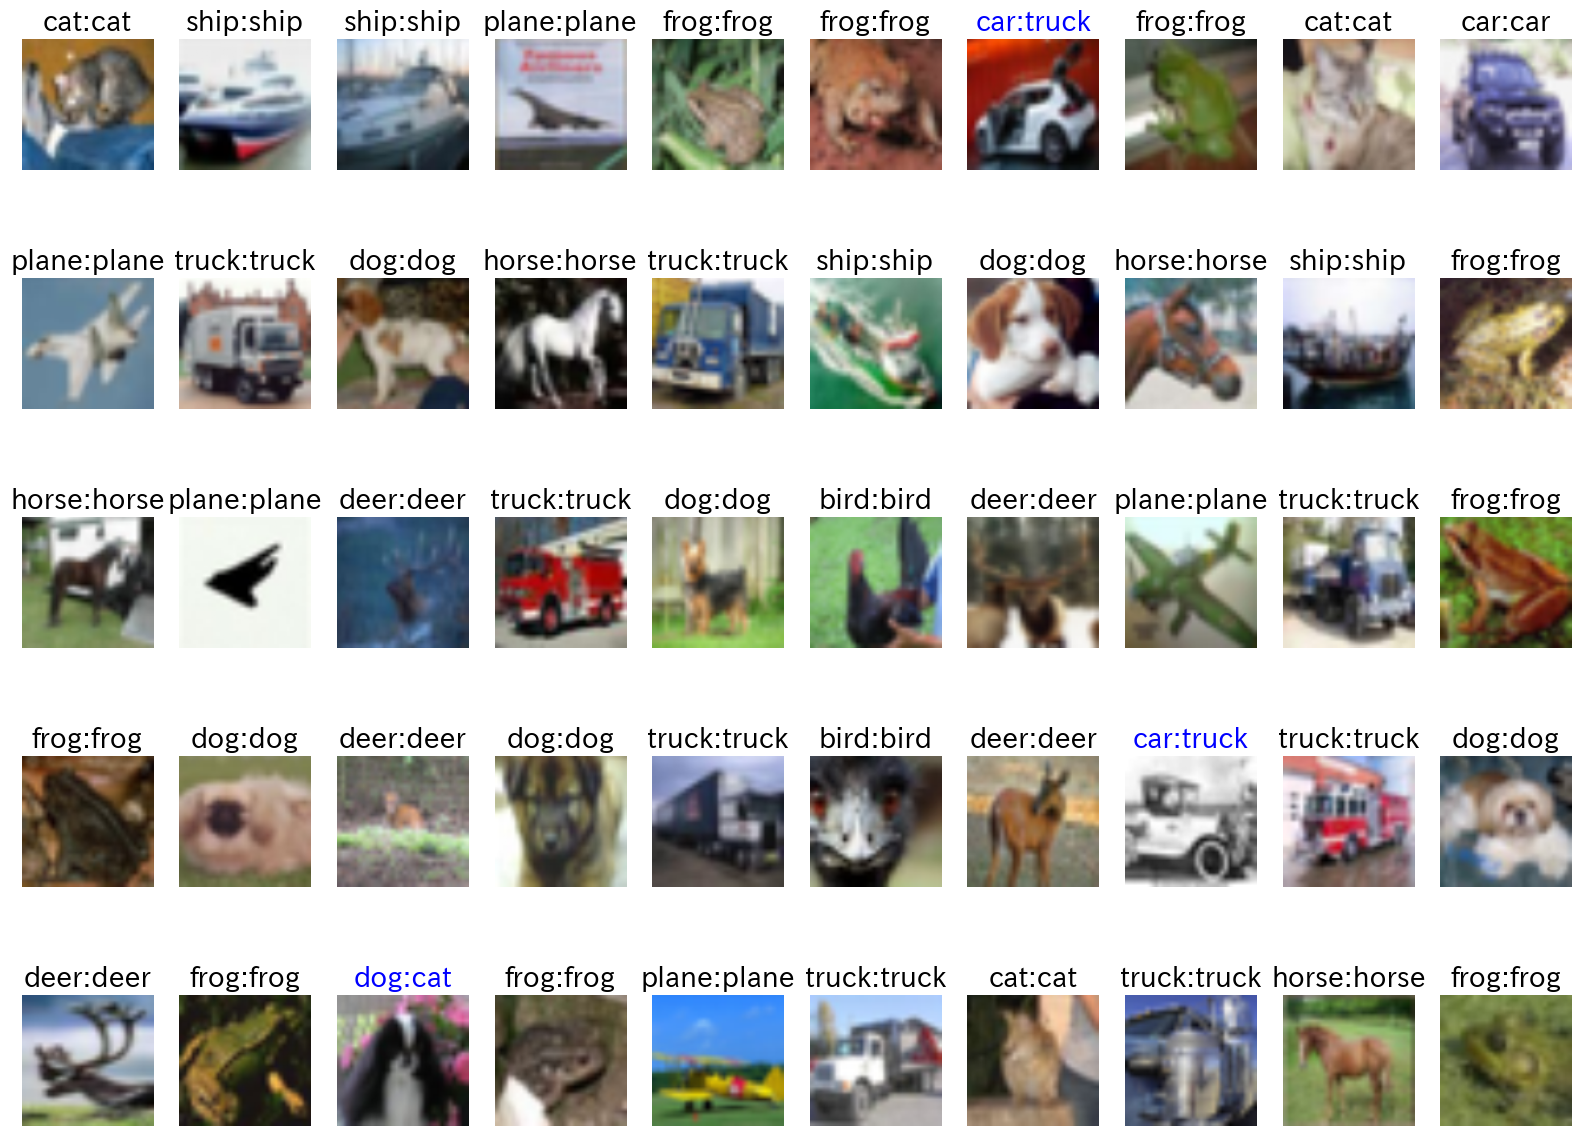

In [47]:
# イメージと正解・予測結果の表示
show_images_labels(test_loader, classes, net, device)

## 11.9 VGG-19-BNの利用

###  モデルの読み込み

In [48]:
# 事前学習済みモデルの読み込み
from torchvision import models
net = models.vgg19_bn(pretrained = True)

###  モデル構造の確認

In [49]:
# モデルの確認
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [50]:
# 最終レイヤー関数の確認
print(net.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


### 最終レイヤー関数の付け替え

In [51]:
# 乱数の初期化
torch_seed()

# 最終レイヤー関数の付け替え
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, n_output)

# features最後のMaxPool2dをはずす
net.features = net.features[:-1]

# AdaptiveAvgPool2dをはずす
net.avgpool = nn.Identity()

In [52]:
# モデルのサマリー表示
net = net.to(device)
summary(net,(100,3,112,112))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 512, 7, 7]          --
│    └─Conv2d: 2-1                       [100, 64, 112, 112]       1,792
│    └─BatchNorm2d: 2-2                  [100, 64, 112, 112]       128
│    └─ReLU: 2-3                         [100, 64, 112, 112]       --
│    └─Conv2d: 2-4                       [100, 64, 112, 112]       36,928
│    └─BatchNorm2d: 2-5                  [100, 64, 112, 112]       128
│    └─ReLU: 2-6                         [100, 64, 112, 112]       --
│    └─MaxPool2d: 2-7                    [100, 64, 56, 56]         --
│    └─Conv2d: 2-8                       [100, 128, 56, 56]        73,856
│    └─BatchNorm2d: 2-9                  [100, 128, 56, 56]        256
│    └─ReLU: 2-10                        [100, 128, 56, 56]        --
│    └─Conv2d: 2-11                      [100, 128, 56, 56]        147,

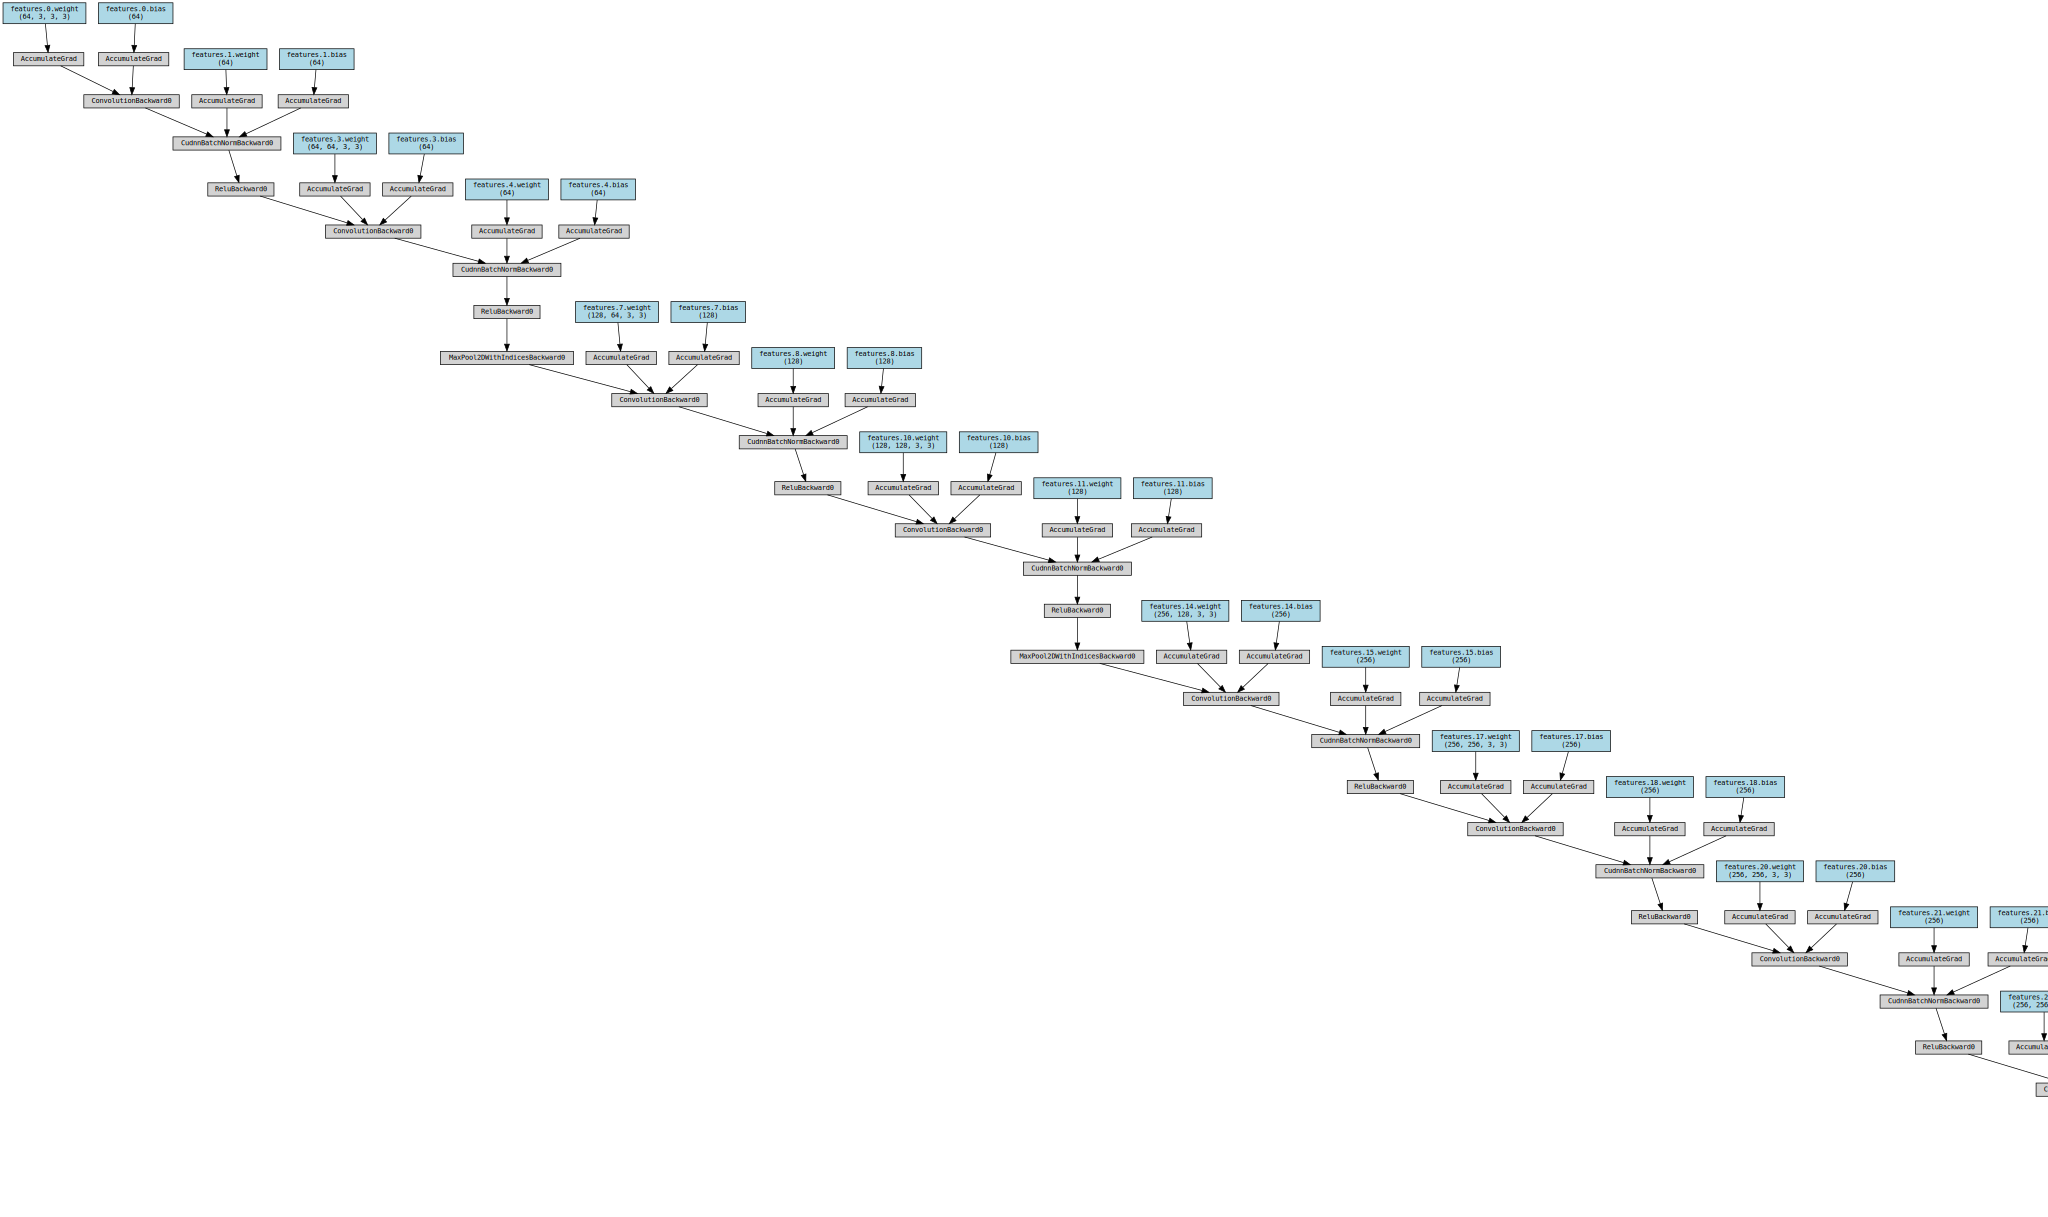

In [53]:
# 損失の計算グラフ可視化

criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 最適化関数などの定義

In [54]:
# 乱数の初期化
torch_seed()

# 事前学習済みモデルの読み込み
net = models.vgg19_bn(pretrained = True)

# 最終レイヤー関数の付け替え
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, n_output)

# features最後のMaxPool2dをはずす
net.features = net.features[:-1]

# AdaptiveAvgPool2dをはずす
net.avgpool = nn.Identity()

# モデルをGPUに送付
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# historyの初期化
history = np.zeros((0, 5))


In [55]:
# 学習

num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs,
        train_loader, test_loader, device, history)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.49749 acc: 0.83278 val_loss: 0.19492, val_acc: 0.93320


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.24103 acc: 0.91808 val_loss: 0.15267, val_acc: 0.94810


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.18317 acc: 0.93834 val_loss: 0.13596, val_acc: 0.95380


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.15202 acc: 0.94876 val_loss: 0.12582, val_acc: 0.95810


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.13342 acc: 0.95516 val_loss: 0.12197, val_acc: 0.95880


### 結果確認

初期状態: 損失: 0.19492 精度: 0.93320
最終状態: 損失: 0.12197 精度: 0.95880


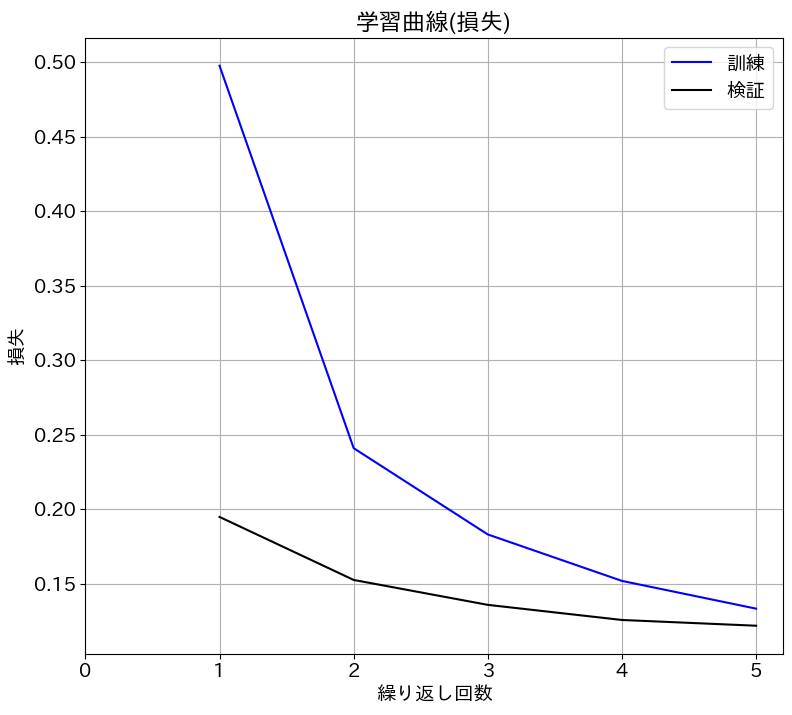

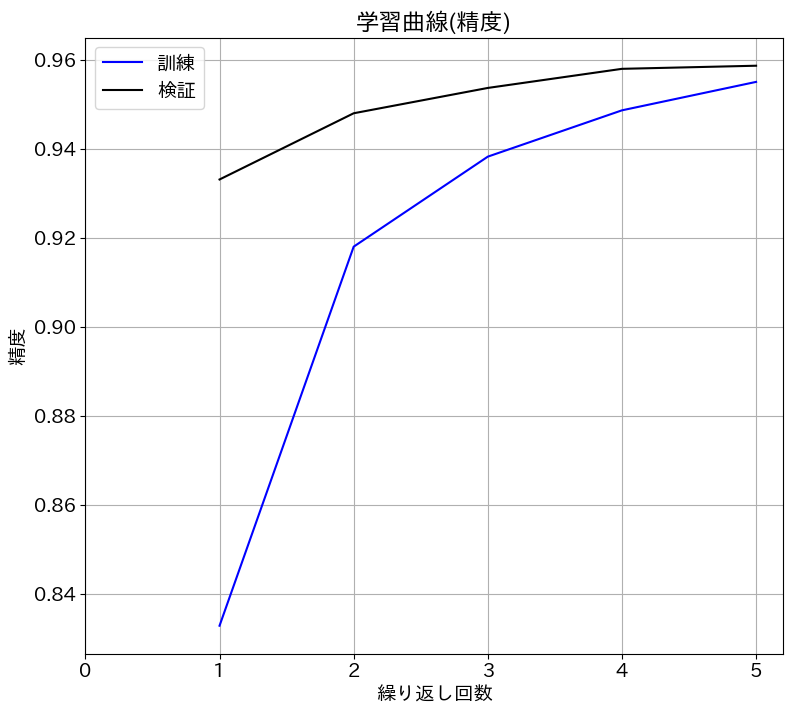

In [56]:
# 結果サマリー
evaluate_history(history)

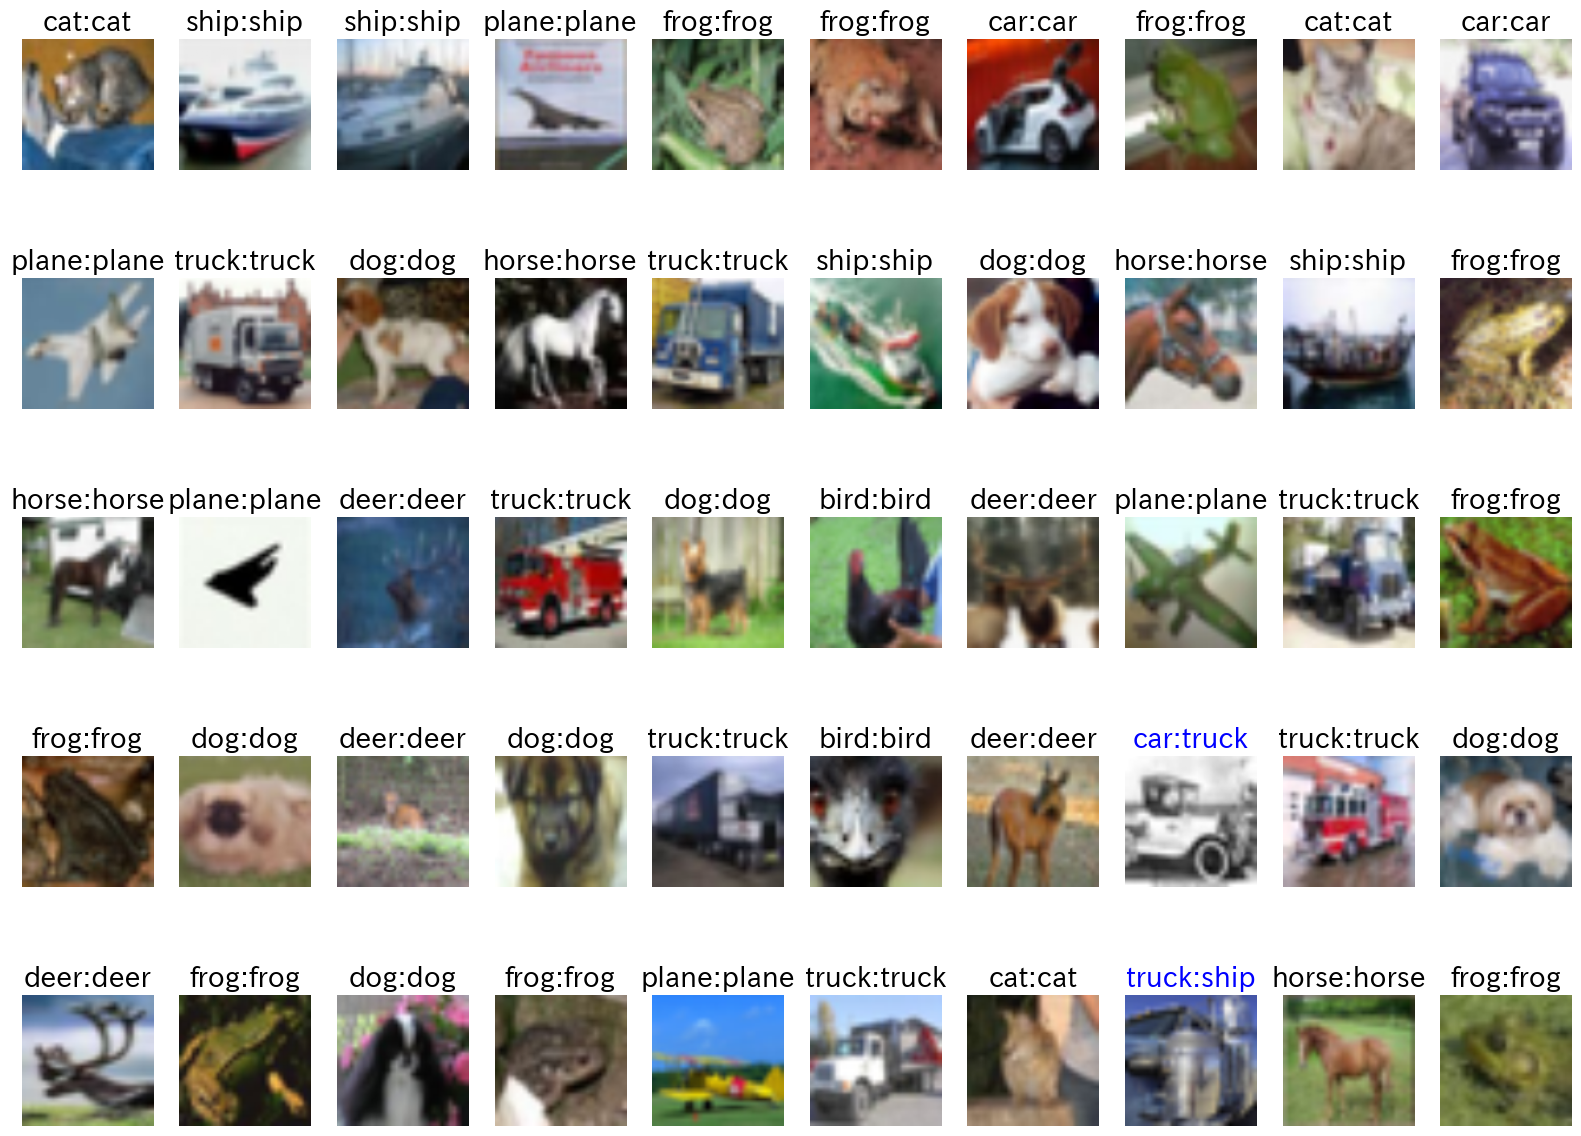

In [57]:
# イメージと正解・予測結果の表示
show_images_labels(test_loader, classes, net, device)

## コラム CIFAR-10に転移学習を適用した場合


In [58]:
# 転移学習バージョン

# 事前学習済みモデルの読み込み
net = models.resnet18(pretrained = True)

# すべてのパラメータで勾配計算をOFFにする
for param in net.parameters():
    param.requires_grad = False

# 乱数初期化
torch_seed()

# 最終レイヤー関数の付け替え
net.fc = nn.Linear(net.fc.in_features, n_output)

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
# パラメータ変更は最終レイヤー関数に限定
optimizer = optim.SGD(net.fc.parameters(), lr=lr, momentum=0.9)

# historyファイル初期化する
history = np.zeros((0, 5))

In [59]:
# 学習

num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs,
        train_loader, test_loader, device, history)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/5], loss: 1.16834 acc: 0.60836 val_loss: 0.80845, val_acc: 0.72880


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.96574 acc: 0.66876 val_loss: 0.76900, val_acc: 0.74090


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.93370 acc: 0.67928 val_loss: 0.74172, val_acc: 0.74790


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.92052 acc: 0.68138 val_loss: 0.72353, val_acc: 0.75640


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.91013 acc: 0.68562 val_loss: 0.72433, val_acc: 0.75340


初期状態: 損失: 0.80845 精度: 0.72880
最終状態: 損失: 0.72433 精度: 0.75340


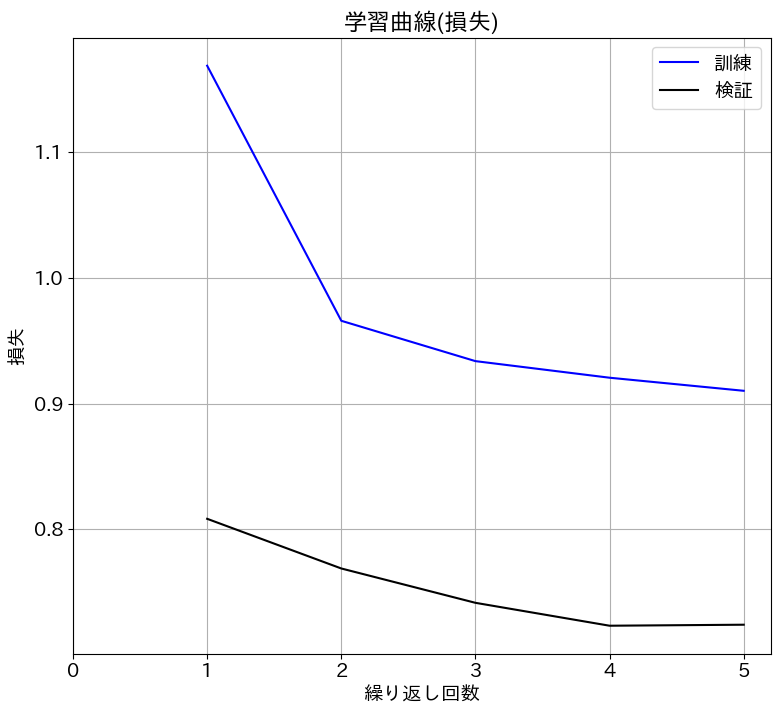

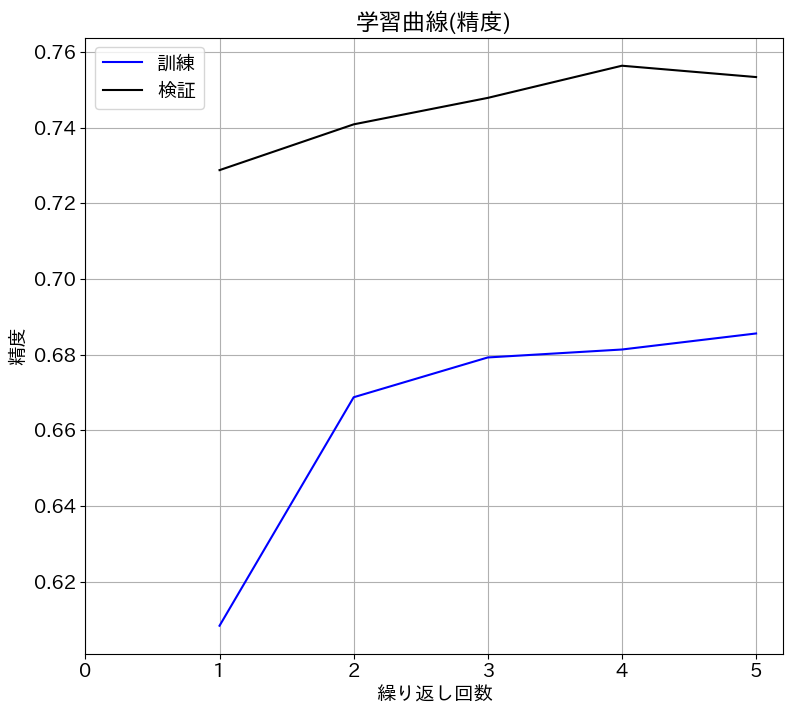

In [60]:
# 結果サマリー

evaluate_history(history)